# Обработка видео. Классификация датасета KTH
Классификация действий по видео


In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Подготовка датасета для классификации

In [4]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io


if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

     |████████████████████████████████| 2.3MB 9.6MB/s 
--2020-06-05 21:27:07--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-06-05 21:27:09--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [ <=>                ] 231.21M  3.17MB/s    in 79s     

2020-06-05 21:28:30 (2.93 MB/s) - ‘walking.zip’ saved [242442411]

--2020-06-05 21:28:33--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.s

### Подготовка датасета к классификации

In [8]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


### Визуализация кадра из видео

videodata shape: (502, 120, 160, 3)


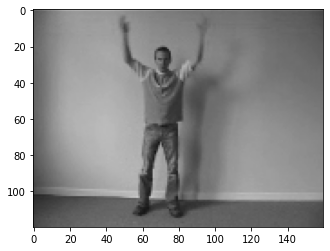

In [7]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (501, 120, 160, 1)


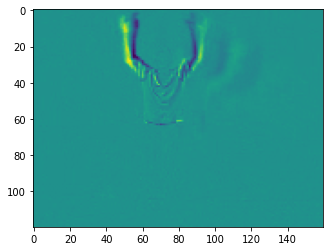

In [9]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

### Построение модели

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])


In [15]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 501, 120, 160, 1)
Output shape: (1, 6)


In [0]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [0]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

## Тестирование обученной модели

True class: handwaving
Predicted class: handwaving


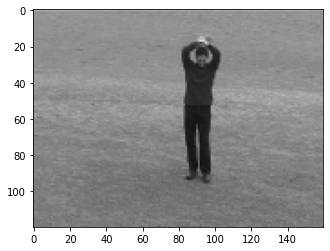

In [22]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])